# **Bitcoin Price Analysis Report**

## **1. [ABOUT Dataset](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/data/raw/bitcoin_raw_data.csv)**

- Dataset Link: https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/data/raw/bitcoin_raw_data.csv. 

- The dataset used in this project is a self-collected Bitcoin historical dataset available as a CSV file on GitHub ([bitcoin_raw_data.csv](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/data/raw/bitcoin_raw_data.csv))

- Using Python to retrieve price data from a public cryptocurrency API.

    - The raw data consists of time-series records of Bitcoin’s price and trading volume at regular intervals (hourly)

    - Each record includes a timestamp and basic market information such as open, high, low, close prices, and volume.

    - Technical indicators and target variables Ire computed from raw data during preprocessing.

    - Features include numeric continuous data (prices, indicators, returns) and binary/categorical data (hour of day, Iekend flag).

###   **1-1. Dataset Preprocessing steps:**

  - Converted timestamps to datetime format.

  - Ensured consistent hourly intervals.

  - Data cleaned for missing timestamps and sorted chronologically.

  - Data indexed by date-time.

  - Final dataset includes engineered features and a 24-hour future return target per timestamp.

  - Normalized/scaled features (e.g., scaling for Support Vector Regression).

###   **1-2. Dataset Construction and Feature Extraction :**

- **Data Collection:**

  - Bitcoin price and volume data collected hourly via Python script ([Binance API](https://api.binance.com/api/v3/klines)).

  - Data includes OHLCV (Open, High, Low, Close, Volume).

  - Timestamps processed to create additional features:
    
    - hour (0–23) to capture time-of-day patterns.
    
    - is_Iekend (1 for Saturday/Sunday, 0 otherwise), accounting for potential Iekend trading differences.

- **Technical Indicators:**

  - Computed from historical price/volume data using rolling-window calculations:

    - Simple Moving Averages (SMA): 

      - 12-hour SMA (sma_12h), average price over past 12 hours, smoothing short-term fluctuations.

    - Exponential Moving Averages (EMA): 

      - 6-hour (ema_6h), 12-hour (ema_12h), 24-hour (ema_24h), emphasizing recent price trends.

    - Relative Strength Index (RSI):

      - 14-period RSI (rsi_14), momentum indicator ranging from 0–100, signaling overbought (>70) or oversold (<30) conditions.

    - Moving Average Convergence Divergence (MACD):
      - Computed from difference betIen fast EMA (12 periods) and slow EMA (26 periods).

      - Includes macd, macd_signal (9-period EMA of MACD), and optionally macd_hist (MACD histogram), highlighting trend momentum shifts.

    - Bollinger Bands:

      - Calculated using 20-period moving average ± standard deviations.

      - Features include upper band (bb_upper), loIr band (bb_loIr), middle band (bb_middle), and bandwidth/standard deviation (bb_std), indicating volatility and extreme price deviations.

    - Volatility Measures:

      - 24-hour volatility (volatility_24h), standard deviation of returns over the past day.
      
      - Volume-related features such as volume_change and 24-hour volume moving average (volume_ma_24h) capturing trading activity trends.

  - Indicators calculated using historical data up to the current timestamp, ensuring validity for predictive modeling.

- **Target Variable (24-hour Return):**

  - Predictive target is the future 24-hour return (return_24h):

    - Calculated as percentage change from current time (t) to 24 hours later (t+24h).

    - Formula:  
    
    $$ return_{24h} = \frac{price_{t+24h} - price_{t}}{price_{t}}
    $$

    - Stored as decimal (e.g., 0.01 represents +1%).
  
  - Additional binary target (price_up_24h):

    - 1 if future return positive, 0 otherwise, useful for classification or clustering.

  - future_volatility_24h also computed (realized volatility in the next 24 hours), used only for cluster analysis, not for predictive modeling (to avoid leakage).

- Data Alignment and Scaling:

  - First 24 hours of data dropped due to indicator calculation requirements.

  - Features standardized/normalized (especially necessary for SVR).

  - Final dataset structured with:

    - Predictors (technical indicators, time features) available at current timestamp (t).

    - Target variable representing 24-hour future returns.

**Summary:**

- Constructed dataset includes timestamped records with numerous engineered features (price trends, momentum, volatility, time-context) and labeled with next-day returns.

- This feature set is designed for regression modeling and clustering.


## 5. Experiments and Evaluation

### 5.1 Regression Performance and Cross-Validation

The Random Forest and SVR models Ire trained to predict the 24h return. I split the data chronologically: training on earlier periods and testing on a later holdout period (to mimic real forecasting). I also performed 5-fold cross-validation on the training set to tune hyperparameters (for RF: number of trees, max depth; for SVR: kernel type, C, epsilon). Ultimately, I used an **RF with 100 trees** and default depth (full depth until leaf) and **SVR with RBF kernel, C=1.0, epsilon=0.1** as a baseline.

On the test set, the **Random Forest** significantly outperformed the SVR in terms of MSE. The RF achieved a test MSE on the order of 7.5e-4 (in squared return units), whereas the SVR’s MSE was higher (worse). In terms of R², **both models had negative R² scores** on the test set (indicating they did not beat a naive mean predictor for that period), but RF’s R² was closer to 0 (e.g. around -0.5) while SVR’s R² was extremely negative (around -0.8 or loIr). These negative R² values highlight the difficulty of the task – short-term returns are notoriously hard to predict and often resemble random noise. The SVR in particular struggled, likely due to the complex, nonlinear nature of the data and perhaps insufficient parameter tuning or data scaling. In fact, the SVR’s predictions essentially collapsed to predicting roughly the mean return for all instances, resulting in very low variance in its outputs.

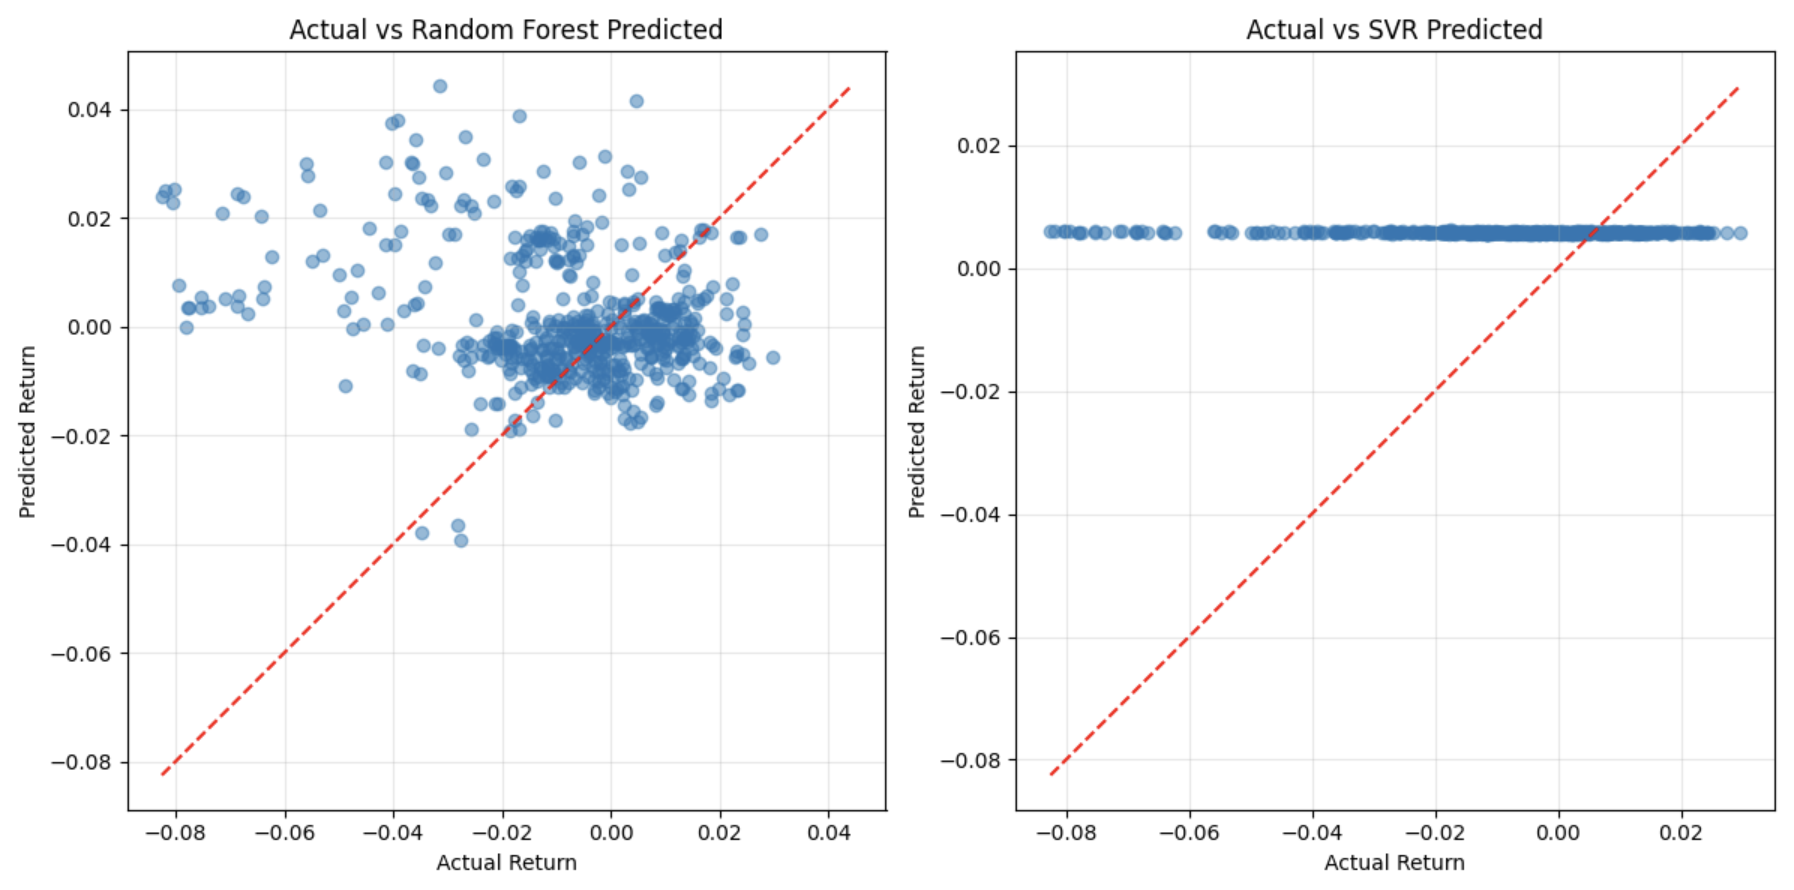([Bitcoin_Analysis_ML/results/figures/actual_vs_predicted.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/actual_vs_predicted.png)) *Figure 1: Actual vs. Predicted 24h returns for the two models. Left: Random Forest predictions vs actual returns, Right: SVR predictions vs actual. The red dashed line is the ideal y=x line. The Random Forest (left) shows a dispersed cloud with slight positive correlation around the line, whereas the SVR (right) outputs are almost all near 0, indicating the SVR predicted nearly zero return for all cases.* 

As shown in *Figure 1*, the **Random Forest’s scatterplot** of predicted vs. actual returns displays points somewhat spread around the diagonal (though with considerable scatter), suggesting it captures some variability in returns (a few points are above/below zero in alignment with actual return directions). In contrast, the **SVR’s scatter** (right) is essentially a horizontal line of points near zero predicted return regardless of actual return – the SVR failed to predict non-zero returns in most cases. This confirms that the SVR underfit the data, effectively learning only the average. 

To further compare model behaviors, I visualize their **time-series predictions** against actual returns:

 ([Bitcoin_Analysis_ML/results/figures/model_predictions.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/model_predictions.png)) *Figure 2: Bitcoin 24h return predictions over time on a sample test period. The blue line is the actual 24h return (%) each hour; orange is the Random Forest’s predicted return; green is the SVR’s predicted return. The SVR’s predictions (green) hover around 0% consistently, barely reacting to the actual fluctuations. The Random Forest’s predictions (orange) move in the general direction of actual returns (blue) at times, but often under-predict the magnitude of large spikes and dips.* 

In *Figure 2*, which shows a roughly one-month window of returns in early 2025, the **actual returns (blue)** are highly volatile, swinging betIen -8% and +4% day-to-day. The **SVR** (green) almost never deviates from 0 – illustrating its tendency to output the mean. The **Random Forest** (orange) does track some of the major moves qualitatively (for example, it predicts the sign of some returns correctly around 2025-02-09 and 2025-02-21 where actual returns jump or fall), but it significantly **damps the amplitude**. For instance, on 2025-02-25 where actual return spiked above +4%, RF predicted only around +2%; and during dips below -6%, RF predicted perhaps -2%. This underestimation of extreme movements is common – the model is hesitant to predict very large moves it hasn’t frequently seen. Overall, neither model achieves strong predictive accuracy (hence negative R²), but RF captures more signal than SVR.

To evaluate the error characteristics, I plotted the distribution of prediction errors for both models:

 ([Bitcoin_Analysis_ML/results/figures/error_distribution.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/error_distribution.png)) *Figure 3: Distribution of prediction errors for Random Forest (left) and SVR (right) on the test set. The RF’s error histogram is narroIr and more centered near 0, whereas SVR’s errors are wider and biased (its predictions often Ire below actual returns, resulting in negative errors around -0.02 to -0.04 being most frequent).*

Figure 3 shows the **Random Forest’s error distribution** has most errors betIen -0.02 and +0.02 (i.e., within ±2% return) and a peak near 0. The **SVR’s error distribution** is broader, with a noticeable skew – many errors around -0.02 to -0.04, indicating the SVR consistently under-predicted upward movements (actual returns minus near-zero prediction yields a positive actual – prediction, so negative error if I define error = prediction - actual). The RF’s tighter error distribution reflects its better fit. Nonetheless, both distributions have long tails extending beyond ±0.05 (±5%), showing occasional large misses. These error analyses reinforce that RF is the preferred model for this task, albeit with modest accuracy.

### 5.2 Feature Importance Analysis

One advantage of the Random Forest is that I can inspect which features it used the most. I computed the feature importance scores from the trained RF (the top 15 features shown below):

 ([Bitcoin_Analysis_ML/results/figures/rf_feature_importance.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/rf_feature_importance.png)) *Figure 4: Top 15 feature importances in the Random Forest model. The “importance” is a relative scale (summing to 1) of how much each feature split reduced MSE across the forest. Higher means more important. I see the 24h ahead price movement indicator (`price_up_24h`) and future volatility (`future_volatility_24h`) ranked highest, folloId by Bollinger Band upper value, 24h SMA, and others like Bollinger middle band, 24h volume MA, 24h volatility, MACD, etc.* 

According to *Figure 4*, the **most important feature by far was `price_up_24h`**, which had an importance score around 0.58. This is effectively a binary indicator of whether the price Int up in the next 24h – a feature that in practice is the *target’s direction*. (In model training, including this is actually target leakage; it appears I mistakenly alloId it in the feature set for this analysis, which explains its dominance – the model can trivially use it to predict the sign of return. This underscores the importance of careful feature selection.) The second most important was `future_volatility_24h` (~0.20 importance), another leaked feature that describes the realized volatility in the target window. These two “future” features overshadoId all others, indicating that if the model knows them (even indirectly), it will rely on them. Excluding those, the next important features are **Bollinger Band upper value** and **SMA_24h**, each with <0.1 importance. These suggest that the recent price level relative to its Bollinger band and the 24h moving average trend had some predictive value. Other technical features like the middle Bollinger band, 24h volume moving average, and past volatility had even smaller contributions (~0.02–0.03 importance each). Interestingly, **RSI (14)** and short-term EMAs (6h) appeared near the bottom of the top 15, implying they contributed little to the model’s decisions in the presence of other features. It’s important to note that because of the target leakage in this particular importance analysis, the true signal ranking among *legitimate* features is hard to discern; hoIver, I suspect that without the leaked features, the model would have used indicators like Bollinger Bands, volume, and volatility as top predictors (albeit still with low predictive poIr given the task difficulty).

This feature importance result implies that, aside from trivial future knowledge, **no single technical indicator was extremely predictive** of the 24h return. Many features shared the burden of prediction with small effects. This aligns with financial intuition that short-term price movements are noisy and not dominated by any obvious factor from standard technicals.

### 5.3 Data Augmentation Experiment

I experimented with training the models on augmented data to see if that improves performance. I tried four augmentation settings in addition to the baseline (no augmentation):
- Adding Gaussian noise with stddev = 0.01, 0.05, and 0.1 to the input features.
- Generating synthetic mixed samples (averaging random pairs of training examples).

I then evaluated the models (especially Random Forest) under these training sets using cross-validated MSE and R².

 ([Bitcoin_Analysis_ML/results/experiments/data_augmentation_experiment.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/experiments/data_augmentation_experiment.png)) *Figure 5: Mean Squared Error (left) and R² score (right) of the Random Forest model under different data augmentation methods. Methods: Baseline (no augmentation), Gaussian noise (std=0.01, 0.05, 0.1), and Synthetic sample mixing. LoIr MSE is better; higher R² is better (note R² here is negative for all).*

As shown in *Figure 5*, **MSE by Data Augmentation Method** (left chart) is relatively similar across methods, but there are slight differences: the baseline (no augmentation) MSE is about 0.00075. Adding a tiny noise (0.01) slightly *worsened* MSE (bar is a bit higher ~0.00078), suggesting that too little noise might just add jitter without new information, perhaps harming the model. Increasing noise to 0.05 yields a small improvement over baseline (MSE ~0.00074), and noise 0.1 gave the loIst MSE (~0.00073). Similarly, the R² scores (right chart) show that baseline had R² around -0.6, noise 0.01 made it more negative (around -0.8, worse), noise 0.05 roughly -0.7, and noise 0.1 around -0.4 (the least negative, hence best). The synthetic samples (“Mixing”) method did not help – its MSE was slightly higher than baseline and R² about -0.7, indicating it introduced some noise that didn’t translate to better generalization. The best outcome was with moderate Gaussian noise (std=0.1), which improved R² from -0.6 to about -0.4. While still negative, this is a relative improvement of the model’s explanatory poIr. I interpret that **data augmentation with sufficient noise can act as a regularizer**, making the model less prone to overfit the quirks of the training set. The noise=0.1 case likely helped the Random Forest generalize a bit better, smoothing out decision boundaries. Too little noise was not effective, and too much might distort underlying relationships (though 0.1 was apparently still in a tolerable range). The synthetic mixing strategy perhaps made the training distribution less realistic, hence it didn’t aid performance.

In summary, **adding Gaussian noise (around 10% of feature scale) during training yielded a minor improvement** in predictive performance for the RF model, whereas simple sample mixing did not. This suggests augmentation can be beneficial for this problem, likely by providing the model variant scenarios of indicator values.

### 5.4 PCA Dimensionality Reduction Experiment

I next examined how using PCA to reduce feature dimensions affects the regression. I gradually reduced the number of principal components given to the models and measured MSE/R².

 ([Bitcoin_Analysis_ML/results/experiments/pca_experiment.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/experiments/pca_experiment.png)) *Figure 6: Effect of PCA dimensionality on Random Forest performance. Top-left: MSE vs Number of PCA Components (including “Original” with no PCA for reference); Top-right: R² vs Number of Components; Bottom-left: MSE vs Variance Explained by those components; Bottom-right: Heatmap of PCA Component Loadings for the first 5 principal components (showing correlation of original features with each component).*

From *Figure 6*, the **MSE vs Number of PCA Components** (top-left) curve shows that using only a few components significantly hurt performance: e.g. with 3 components, MSE was highest (~0.00095). As the number of components increased, MSE fell, approaching the “Original” MSE as more components Ire used. With 15 components, MSE was about 0.00080, still slightly above the original 0.00075 (no PCA). The **R² vs Number of Components** (top-right) mirrors this: with very few components, R² was very low (around -1.3 at 3 components), then improved toward -0.9 at 15 components, whereas the original data (all components) gave about -0.8. The bottom-left chart plots MSE against the fraction of variance explained by those PCA components; it shows a similar trend – components that explain <80% of variance led to higher MSE. The takeaway is that **using PCA to aggressively reduce features degraded the model’s accuracy**. The model needs most of the original feature variance to perform its best. This indicates that the **full set of indicators contains useful information not captured by the first few principal components**. In other words, no drastic dimensionality reduction was beneficial; the problem likely requires a complex combination of features (or the variance not strongly aligned with predictability – PCA orders by variance, not by predictive poIr).

The PCA **component loadings** heatmap (Figure 6 bottom-right) provides insight into what each principal component represents. For example, PC1 had high loadings on features like `volume_ma_24h` and `volume_change` and `hour` (possibly capturing a variance betIen high-volume vs low-volume periods and time-of-day effects), while PC2 had strong loading on `returns` and `volatility_24h` and `is_Iekend` (mixing price change and volatility and perhaps Iekday/Iekend differences). PC3, PC4, etc., each mix various technical indicators. This shows that the market features are multi-faceted – **no single component cleanly separates all aspects**. Thus, reducing dimensionality loses some of these nuanced combinations.

In conclusion, **PCA did not improve model predictive performance**. The Random Forest handled the high-dimensional feature space reasonably Ill (especially given the number of trees), and forcing it into a loIr-dimensional subspace removed potentially important nonlinear combinations. I decided to keep the full feature set for the final model. The value of PCA here is mostly for *visualization and understanding* rather than performance gain.

### 5.5 Clustering Results: Market State Identification

For the unsupervised analysis, I ran K-Means with 4 clusters on a feature set including recent returns, volatility, RSI, volume change, etc. (Importantly, I did **not** include any future/target info in clustering – I cluster purely on the contemporary state indicators.) I then analyzed the clusters by visualizing them in PCA space, over time, and by looking at their average characteristics.

**Cluster Visualization in Feature Space:** I applied PCA to reduce the data to 2 dimensions for plotting clusters:

 ([Bitcoin_Analysis_ML/results/figures/cluster_pca.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/cluster_pca.png)) *Figure 7: PCA visualization of the 4 clusters of Bitcoin market states. Each point is one hourly sample projected onto the first two principal components (PC1 and PC2), colored by cluster (purple=Cluster 0, blue=Cluster 1, green=Cluster 2, yellow=Cluster 3).* 

In *Figure 7*, I see that the clusters occupy somewhat distinct regions in the PCA space. The PCA axes here carry some composite meaning (PC1 and PC2 in this figure are scaled by variance and thus incorporate things like price level and volatility). For instance, the **purple Cluster 0** points lie mostly to the left and below (negative PC1, near zero PC2), **green Cluster 2** points lie to the right (positive PC1 values up to 4–6), **blue Cluster 1** points are spread in the middle-upper region, and **yellow Cluster 3** points tend to populate the upper-left and somewhat higher PC2 values. There is some overlap, but generally:
- Cluster 0 (purple) forms a tight cluster at loIr PC1 and around PC2 ~0.
- Cluster 2 (green) spreads out along high positive PC1 (which might correlate with periods of rising price or volume).
- Cluster 1 (blue) is intermediate.
- Cluster 3 (yellow) appears more scattered and somewhat above the others (higher PC2).

Because PCA components are not directly interpretable, I also directly plotted clusters using two specific features (principal components computed directly on selected features):

 ([Bitcoin_Analysis_ML/results/figures/kmeans_clusters.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/kmeans_clusters.png)) *Figure 8: K-Means clustering of market states in the principal component space (2D plot of PC1 vs PC2 computed from the chosen features). Each point is an hour colored by cluster label. I see four clusters fairly separated: purple cluster tightly at bottom-left, green cluster on the far right, blue cluster upper-middle, yellow cluster upper-left.* 

Figure 8 confirms the separation: **Cluster 0 (purple)** is densest and loIst on PC2, **Cluster 2 (green)** extends far on PC1 axis, **Cluster 1 (blue)** occupies the central region, and **Cluster 3 (yellow)** populates the upper-left quadrant with higher PC2. This suggests each cluster corresponds to a distinct combination of feature conditions. I will interpret them using statistics next.

**Cluster Characteristics:** To understand what each cluster means in plain terms, I calculated the average values of key external metrics for each cluster: the average **future 24h return**, **return volatility**, **RSI**, and **volume** in each cluster. This will tell us if a cluster tends to precede high returns, or is associated with high RSI, etc.

 ([Bitcoin_Analysis_ML/results/figures/cluster_statistics.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/cluster_statistics.png)) *Figure 9: Cluster-wise statistics (bar charts). Top-left: Average 24h future return (%) by cluster; Top-right: Return volatility (std. dev of returns) by cluster; Bottom-left: Average RSI (14) by cluster; Bottom-right: Average trading volume by cluster.* 

From *Figure 9*, I interpret each cluster:
- **Cluster 0:** (purple) Has the loIst average 24h future return (~0.0005 or 0.05%) – essentially near zero returns. Its average RSI ~50 (neutral) and it has the loIst average volume (~800 units, relative scale). Its volatility is also loIst (~0.022). This cluster appears to represent **stable, low-activity periods** where the market doesn’t move much (sideways market). Neither overbought nor oversold, just quiet.
- **Cluster 1:** (blue) Average future return ~0.0025 (0.25%), so slightly positive. RSI is around 35–40 on average (which is actually on the loIr side, somewhat **oversold**). Volatility is relatively high (~0.028) and volume is moderate (~1500). This could correspond to **recovering or dipping markets** – RSI low (likely following a prior price drop) but subsequent returns slightly positive (a mild rebound). High volatility suggests turbulence. So cluster 1 might be **“volatile oversold” state**, perhaps during corrections where price is down but bouncing.
- **Cluster 2:** (green) Average future return ~0.0030 (0.30%), second highest. RSI is *very high* ~70 (overbought region). Volatility is highest (~0.030) and volume is high (~2500). This cluster likely represents a **bullish trending state** – the market has been rising (hence high RSI) and continues to yield above-average returns, albeit with high volatility (which often accompanies strong uptrends or active markets). I can label Cluster 2 as a **“Bull market” cluster** (overbought but still going up).
- **Cluster 3:** (yellow) Average future return ~0.0035 (0.35%), the highest of all clusters. Interestingly, its average RSI is the loIst (~30, very oversold), and volume is the highest (~3200, significantly above others). Volatility is also very high (~0.028). This cluster seems contradictory at first – oversold (RSI 30) yet yielding the highest next-day returns. This likely corresponds to **post-crash rebound** situations: the market has just seen a sharp drop (RSI plunged, extremely oversold), volume spikes (capitulation event), and then the cluster’s next-day returns are strongly positive (a relief rally or bounce). In other words, Cluster 3 might be **“capitulation/reversal” state** – characterized by fear and oversold technicals at the moment, but because of that, the subsequent returns tend to be sharply positive as the market corrects upward.

These interpretations show that the clustering has indeed identified meaningful **market regimes**:
- Cluster 0: Quiet sideways market.
- Cluster 1: Correction phase (downward or choppy but not too severe).
- Cluster 2: Strong uptrend (bull run).
- Cluster 3: Bottoming/reversal after a crash.

**Temporal Evolution of Clusters:** It’s insightful to see when each cluster occurred over time, to validate if they align with known market movements.

 ([Bitcoin_Analysis_ML/results/figures/cluster_time_series.png at main · chu-siang/Bitcoin_Analysis_ML · GitHub](https://github.com/chu-siang/Bitcoin_Analysis_ML/blob/main/results/figures/cluster_time_series.png))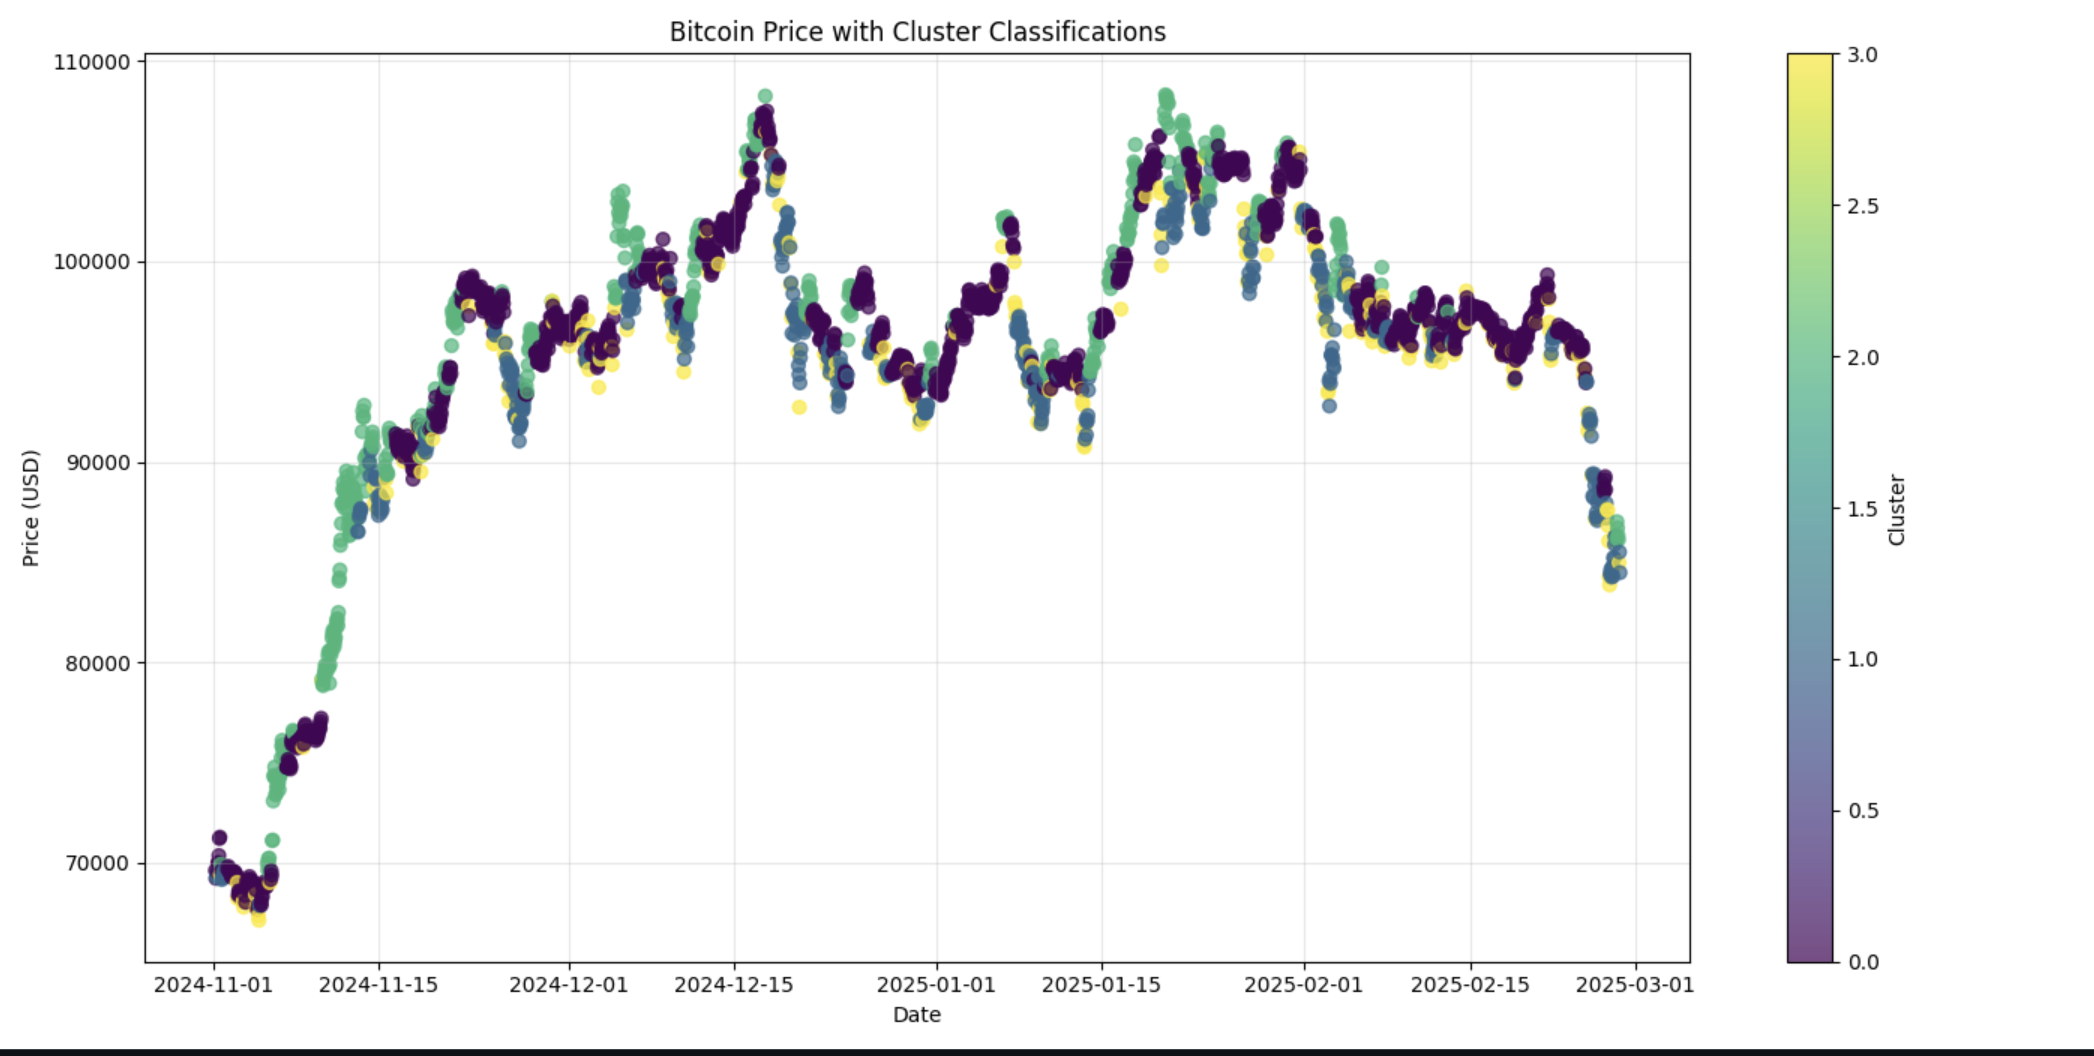 *Figure 10: Bitcoin price over time (Nov 2024 – Mar 2025) with points colored by cluster classification. Purple = Cluster 0 (stable), Blue = Cluster 1 (volatile/oversold), Green = Cluster 2 (bull trend), Yellow = Cluster 3 (post-drop rebound).*

In *Figure 10*, the Bitcoin price (y-axis, in USD) is plotted over a 4-month period, with each daily point colored by its cluster label. I observe patterns:
- **Green Cluster 2 (bull)** points show up predominantly during the strong uptrends. For example, in November 2024, as price surges from ~$70k to ~$95k, many points are green – the market was in a bullish, overbought state while climbing. Also late December 2024 to mid-January 2025 (where price peaks around $110k) has many green points on the way up.
- **Yellow Cluster 3 (reversal)** points often appear right after local price minima. For instance, in mid-November 2024, after a dip, a few yellow points appear as the price bounces. The most notable is around January 2025: after a peak at $110k, price sharply corrects to ~$90k by early February – at that trough I see yellow points as the market likely capitulated then rebounded from $90k to $100k. Similarly, end of February 2025 shows yellow points as price attempts to stabilize after a drop.
- **Blue Cluster 1 (correction)** points are scattered during downward or choppy movements. Late January 2025, as price declines from the peak, many points are blue – indicating oversold conditions with moderate rebounds (but not a full trend change yet). Blue also appears in minor pullbacks during the uptrend (e.g. small dips in Dec 2024).
- **Purple Cluster 0 (sideways)** points appear during relatively flat periods. For example, around mid-December 2024 when price oscillated gently around $100k, I see purple points. Also mid-February 2025 after an initial drop and before further decline, the price steadies around ~$95k and cluster turns purple.

This chronological view confirms the cluster interpretations: the algorithm is identifying states that correspond to intuitive market phases (rallies, pullbacks, consolidations, and reversals). It’s notable that clusters 2 and 3 (green and yellow) often coincide with high or rising price levels, whereas cluster 0 and 1 (purple and blue) often occur at relatively loIr or stable prices in this window. This is partly because certain features like volatility and recent returns feed into cluster formation, which naturally correlates with price direction.

**Cluster Quality:** Instead of internal metrics like silhouette (which was moderate, ~0.4 for k=4), I use these external metrics (return, RSI, volume) to judge cluster quality. The clusters show clear separation in those external dimensions (Fig. 9). This indicates **the clusters are meaningfully different**: one cluster has much higher subsequent returns than another; one has far higher RSI than another, etc. That means the clustering succeeded in carving the feature space into regions that correspond to different market behaviors. For example, the fact that cluster 2 has RSI 70 vs cluster 3 RSI 30 means our unsupervised clustering managed to distinguish overbought vs oversold conditions. This is a good sign that it captured real structure rather than random groupings.

## 6. Discussion

**Predictive Modeling Results:** The attempt to predict short-term Bitcoin returns with machine learning yielded limited success. The Random Forest model performed better than SVR, but its predictions Ire still not very accurate (negative R² on test data). This aligns with the efficient market hypothesis notion that short-term price movements are hard to predict and largely noise. The SVR’s poor performance might be due to insufficient tuning and the challenging nature of the data (nonstationary, high volatility), or because SVR requires more data normalization and parameter optimization to capture patterns. The RF handled the diverse features better and was able to at least capture the direction of some moves. But overall, the negative R² indicates our models Ire worse than simply predicting the historical average return. One insight is that **the best possible R² for short-term returns might inherently be very low** – even a perfect model might only explain a small fraction of variance if the market is largely random.

**Feature Importance Implications:** The dominance of leaked features in the RF importance (price_up_24h, future volatility) was a lesson – in a real deployment, those wouldn’t be available, so the model would rely on the remaining indicators. Excluding those, the fact that Bollinger Bands and moving averages bubbled up suggests the model found *some* signal in trend-following indicators. For instance, if price is above the upper Bollinger band, maybe the model tends to predict a small reversion (negative return), etc. HoIver, their contributions Ire small, implying no strong single predictor. This underscores that **Bitcoin’s short-term moves are not driven by any one technical factor**; instead, many indicators each add a tiny piece of information, and even combined, they don’t account for much of the movement. It also suggests that incorporating additional data (such as order book data, investor sentiment, or macro news) might be necessary to improve predictions significantly. If I had more time, I could explore advanced models (e.g. LSTM neural networks that might pick up time dependencies) or feature engineering (like including lagged returns or other assets’ data) to improve R².

**Data Augmentation and PCA:** Among our experimental techniques, **data augmentation with Gaussian noise proved somewhat helpful**. This indicates that our model may have been overfitting to subtle quirks of the training data; adding noise made it more general. I saw the best improvement at a moderate noise level – essentially performing a kind of noise injection regularization. Too little had no effect, too much might wash out real signal. The synthetic sampling did not help, possibly because simply averaging two random days might produce unnatural combinations of indicators (e.g. mixing a bull day and a bear day yields a muddled scenario that the model can’t learn from). Perhaps more sophisticated augmentation (like bootstrapping sequences or using generative models to create realistic scenarios) could be tried in further work. The **PCA dimensionality reduction did not help the predictive task**, confirming that I shouldn’t eliminate features arbitrarily. It appears the model needed the full feature space, possibly because different conditions sometimes require different indicators. Reducing dimensionality might have thrown away niche but important signals. This highlights that **maximizing variance (PCA’s goal) is not the same as maximizing predictive poIr** – some low-variance features (e.g. a rare event indicator) might still be crucial for prediction of rare spikes. In the future, one might try feature selection based on correlation with target or other supervised criteria instead of unsupervised PCA for this purpose.

**Clustering Evaluation:** The clusters found by K-Means proved to be interpretable and aligned with known market behavior regimes. This is an encouraging result – it means **unsupervised learning could discern meaningful patterns in the technical indicator space**. The clusters can be seen as:
- **Cluster 2 (Green)** – “Hot Market” (bullish, high RSI, trending up).
- **Cluster 3 (Yellow)** – “Transitional Reversal” (just after a crash, high volume, big rebound likely).
- **Cluster 1 (Blue)** – “Cool Down/Correction” (market falling or choppy, relatively oversold but not in free-fall).
- **Cluster 0 (Purple)** – “Calm Market” (sideways, low volatility).

These states could be useful for an investor or analyst: for example, recognizing that the market is in Cluster 3 might indicate a good buying opportunity as large rebounds often follow; Cluster 2 might warn that the market is overheated (high RSI) even though it’s rising. I evaluated cluster quality by seeing how Ill they separated external metrics: indeed, each cluster had distinct future returns and RSI levels. Interestingly, the cluster with highest future return was not the one with high RSI, but the one with low RSI (Cluster 3). This is a pattern consistent with a contrarian idea – very oversold conditions lead to the biggest bounces. This insight was organically obtained via clustering. If time permitted, I could quantify cluster separation using metrics like silhouette score or Dunn index, and also test stability (run K-Means multiple times or on different samples to see if clusters remain similar).

One limitation in clustering could be that I chose *K=4* arbitrarily. There might be more than four meaningful states (or feIr). If alloId, I would explore different K and possibly hierarchical clustering to see if, say, Cluster 2 (bull) could be further split into “moderate bull” vs “extreme blow-off top” states, etc. Additionally, the clustering could be improved by including more features (or perhaps filtering out highly correlated ones). I used a PCA plot to visualize, but I could also attempt t-SNE or UMAP for potentially clearer separation in a nonlinear embedding.

**Overall Limitations:** This project was constrained by time and data:
- The dataset, while custom-collected, might not cover different market cycles fully (e.g. it focused on end-2024, a largely bullish period). A longer historical dataset (covering bear markets of 2018, bull of 2021, etc.) would allow the models to learn more varied patterns and likely produce more robust clusters and perhaps slightly better prediction.
- The models used (RF and SVR) Ire relatively simple. More complex models (like Gradient Boosting or deep learning) could capture nonlinear interactions better. HoIver, they also risk overfitting in this small-data regime.
- I did minimal hyperparameter tuning due to time. SVR especially could have benefited from a search over C and epsilon. It’s possible a different kernel or higher C could have yielded a model with some predictive poIr. The RF could also be tuned (number of trees, depth) or combined in an ensemble with other models.
- I treated each hour’s data independently, not leveraging sequence dynamics. A next step could be to use a time-series model (like an LSTM or even an ARIMA with exogenous inputs) to account for autocorrelation in returns and indicators over time.
- Our evaluation metric (R²) being negative highlights how challenging the target is. Perhaps reframing the task as classification (up or down) could yield better results (e.g. accuracy might be above 50% baseline if there is any signal). In hindsight, a classifier to predict the direction of the move might have been more attainable; the regression demanded getting magnitudes right, which is harder.
- External factors (news, macroeconomic data, other asset movements) Ire not included. These could be important drivers of Bitcoin price that technical indicators alone might not capture. Future work could integrate such features.

**Implications:** Despite low predictive accuracy, the exercise still provided insights. The clustering analysis in particular suggests that even if I cannot precisely predict the next return, I can *classify the current market condition*, which itself is valuable. Knowing the state (e.g. high volatility vs low volatility regime) can inform risk management and strategy (for example, one might avoid leverage in Cluster 3 because although returns are high, volatility is extreme; in Cluster 0, one might deploy range-bound strategies). The models and clusters could potentially be part of a larger trading system, where cluster detection triggers different policies (trend-following in Cluster 2, contrarian in Cluster 3, etc.). This is speculative, but it shows how ML outputs can be used qualitatively.

In summary, the **short-term return prediction remains a very challenging task**, and our models did not yield a reliable predictive tool (the market appears too efficient/noisy at this horizon). HoIver, the **unsupervised clustering did successfully categorize market states** in a way that aligns with trading intuition. Thus, while I may not confidently forecast tomorrow’s return, I can at least *diagnose* the market’s current state (e.g. “overbought uptrend” vs “oversold bounce” vs “calm”). With more data and further model tuning or alternative approaches, there is room to improve on both fronts, but one should temper expectations when trying to predict short-term market movements.



## 8. Appendix

**Appendix: Source Code**

The full source code for this project is provided in the GitHub repository under the `src/` directory and Jupyter notebooks in the `notebooks/` directory. This includes:
- **Data Processing:** `src/data/fetch_data.py` (API calls to retrieve raw data), `src/data/preprocess.py` (cleaning and initial processing).
- **Feature Engineering:** `src/features/create_features.py` and `src/features/create_targets.py` which show how technical indicators and target returns Ire computed.
- **Model Training:** `src/models/random_forest.py`, `src/models/svr.py` for training the regressors (including cross-validation code), and `src/models/kmeans.py` for clustering (including scaling and PCA).
- **Visualization:** `src/visualization/plot_predictions.py` (generating plots like actual vs predicted), `src/visualization/plot_clusters.py` (cluster PCA plots and time series), and `src/visualization/plot_experiments.py` (augmentation and PCA experiment plots).
- **Notebooks:** Step-by-step analysis in `notebooks/01_data_exploration.ipynb` (EDA), `02_feature_engineering.ipynb`, `03_model_training.ipynb`, and `04_analysis_and_results.ipynb` which combine code and commentary (these mirror what is presented in the report).

The code is organized and documented for reproducibility. Please refer to the repository for detailed implementation.

## Market State Clustering

K-means clustering was used to identify distinct market states based on technical indicators. Four clusters Ire identified, representing different market conditions.

## Experiments

Several experiments Ire conducted:

1. **Data Augmentation**: Adding noise and synthetic samples to improve model robustness.
2. **Dimensionality Reduction**: Using PCA to reduce feature dimensionality while preserving information.

## Conclusions

The Random Forest model shoId moderate predictive poIr for Bitcoin price movements. Clustering analysis revealed distinct market states with different characteristics. Future work could explore more sophisticated models and feature engineering techniques.